# Part 1: Benefits of TOON for Hebbia

**Token-Oriented Object Notation as a Surgical Optimization for LLM Payloads**

> **Note:** All structures shown here use public information from Hebbia blog posts and synthetic schemas derived from them. Nothing here assumes access to internal or propietary data.

---

## Abstract

Hebbia pushes large mixed-mode payloads (tables, citations, agent traces, and long text) through a deeply pipelined LLM stack. Most of those tokens are immutable raw text; only the structured shell around that text is negotiable.

[**TOON**](https://github.com/toon-format/toon) is an indentation-based serialization format that compresses uniform arrays of objects by collapsing repeated keys into a shared header and rendering values in a tabular layout. On paper, TOON can reduce syntax overhead by 30–60% compared with pretty printed JSON for those structures.

This notebook tests a more realistic question for Hebbia:
  Relative to minified JSON, where (if anywhere) does TOON provide non-trivial token savings on Matrix workloads?

### What is TOON?

[**TOON**](https://github.com/toon-format/toon) is an open-source, indentation-based serialization format that encodes JSON more compactly, reducing syntax overhead for LLMs. It achieves significant token reductions (often 30–60%) on uniform arrays of objects by combining YAML/Python-style indentation with CSV tabularization.

When applied selectively to the TOON-eligible segments of Hebbia’s context footprint, this can potentially reduce LLM input tokens globally by **5–25%** depending on workflow. These ranges incorporate:
- Actual Hebbia context composition: estimated 70–85% of tokens are raw unstructured text (not TOON-eligible)
- ISD constraint: snippet text content dominates; only metadata compresses
- Matrix Agent 2.0 design: most compression applies to headers + structured messages, not free-form reasoning

TOON is not a replacement for context distillation or JSON. It is a deterministic layer of syntax compression. From analyzing Hebbia-style workflows, there are multiple data structures that can be (partially) encoded in TOON, using significantly lower LLM input tokens:

| Data Type | Token Savings | Best Use Case |
| --------- | ------------: | ------------- |
| **Matrix / strip-profile rows** (uniform objects) | **40–60%** | Matrix grid rows, strip profiles |
| **ISD citation objects** (Mildly nested/semi-structured) | **15–30%** | metadata only; snippet text unchanged (bulk of tokens) |
| **Agent 2.0 context headers** (hybrid TOON + JSON) | **10–25%** | Turn-level metrics + message headers |

These ranges apply only to **uniform arrays of objects and shallow headers**, where TOON preforms best; deeply nested or highly heterogeneous structures remain in JSON.

### Estimated Annual Savings

Hebbia does **>250B tkns/month** or at least **3T tkns/yr** as of [May 2025](https://www.hebbia.com/blog/maximizer-hebbias-distributed-system-for-high-scale-llm-request-scheduling), which I can only assume is increasing at an exponential rate (with model costs getting cheaper). At enterprise blended rates for the frontier models ($1–3/1M tkns), total LLM spend alone is roughly **$3–9 million per year**.

Assuming a significant share of Hebbia’s context (Matrix rows, citation tables, and turn-level headers) remains structurally uniform after Agent 2.0’s distillation, and TOON typically reduces the token footprint of these tabular structures by [30–60%](https://github.com/toon-format/toon?tab=readme-ov-file#key-features), the practical complete impact of selective TOON encoding is **5–25%** when applied to TOON-eligible portions of the context.

| Scenario | Global Reduction | Annual Savings |
| :--- | :--- | :--- |
| **Conservative** | **5–10%** | **$150k – 900k** |
| **Base** | **10–20%** | **$300k – 1.8 M** |
| **Aggressive** | **20–25%** | **$600k – 2.25 M** |

**Important:** These savings apply to the structured portions only. Across all Hebbia workflows,
~80% of context tokens are raw text (not TOON-eligible). Platform-wide effective savings 
are estimated at **5-10%** of total tokens, concentrated in heavy structured workflows.

### Why TOON Fits Hebbia's Architecture

* **Orthogonal to [Maximizer](https://www.hebbia.com/blog/maximizer-hebbias-distributed-system-for-high-scale-llm-request-scheduling)**: Maximizer optimises rate limit **capacity utilization**, while TOON minimizes the **payload**.
* **Complements [context distillation](https://www.hebbia.com/blog/inside-hebbias-deeper-research-agent)**: After Matrix Agent 2.0 compresses context semantically, TOON further reduces syntactic overhead on the **structured portions (tables, headers, metrics)**.
* **Schema-aware**: Agent 2.0's [strongly-typed contexts](https://www.hebbia.com/blog/divide-and-conquer-hebbias-multi-agent-redesign) map naturally to TOON's header-based format.
* **Selective application**: Enable TOON for **uniform, shallow arrays** (Matrix rows, ISD citations, turn-level headers); keep **deeply nested fields (e.g. `tool_args`, `partitions`) and free-form text** in JSON / raw text.

### Example of JSON vs TOON

<table>
<tr>
<th>JSON</th>
<th>TOON</th>
</tr>
<tr>
<td style="vertical-align: top;">
<pre>
{
  "context": {
    "task": "Our favorite hikes together",
    "location": "Boulder",
    "season": "spring_2025"
  },
  "friends": ["ana", "luis", "sam"],
  "hikes": [
    {
      "id": 1,
      "name": "Blue Lake Trail",
      "distanceKm": 7.5,
      "elevationGain": 320,
      "companion": "ana",
      "wasSunny": true
    },
    {
      "id": 2,
      "name": "Ridge Overlook",
      "distanceKm": 9.2,
      "elevationGain": 540,
      "companion": "luis",
      "wasSunny": false
    },
    {
      "id": 3,
      "name": "Wildflower Loop",
      "distanceKm": 5.1,
      "elevationGain": 180,
      "companion": "sam",
      "wasSunny": true
    }
  ]
}
</pre>
</td>
<td style="vertical-align: top;">
<pre>
context:
  task: Our favorite hikes together
  location: Boulder
  season: spring_2025
friends[3]: ana,luis,sam
hikes[3]{id,name,distanceKm,elevationGain,companion,wasSunny}:
  1,Blue Lake Trail,7.5,320,ana,true
  2,Ridge Overlook,9.2,540,luis,false
  3,Wildflower Loop,5.1,180,sam,true
</pre>
</td>
</tr>
</table>

## Table of Contents

1. [Setup & Configuration](#1-setup--configuration)
2. [The 3 Hebbia-Style Schemas](#2-the-3-hebbia-style-schemas)
3. [Benchmark 1: Matrix Strip-Profile Rows](#3-benchmark-1-matrix-strip-profile-rows)
4. [Benchmark 2: ISD Citation Objects](#4-benchmark-2-isd-citation-objects)
5. [Benchmark 3: Agent 2.0 Context History](#5-benchmark-3-agent-20-context-history)
6. [Benchmark 4: End-to-End Research Turn](#6-benchmark-4-end-to-end-research-turn)
7. [Live LLM Accuracy Validation (Optional)](#7-live-llm-accuracy-validation-optional)
8. [Hebbia-Scale Cost Analysis](#8-hebbia-scale-cost-analysis)
9. [Context Compression & Caching](#9-context-compression--caching)
10. [Q&A: Anticipated Objections](#10-qa-anticipated-objections)
11. [Implementation Roadmap](#11-implementation-roadmap)


---

## 1. Setup


In [51]:
import sys
import os
import json
import time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Any, Optional
import importlib

# Add benchmarks directory to path
sys.path.insert(0, str(Path("../benchmarks").resolve()))

if 'toon_benchmark' in sys.modules:
    importlib.reload(sys.modules['toon_benchmark'])

import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x:,.1f}' if abs(x) < 100 else f'{x:,.0f}')

# Import benchmark utilities
from toon_benchmark import (
    encode_toon,
    count_tokens,
    compare_formats,
    run_benchmark,
    build_prompt_with_json,
    build_prompt_with_toon,
    compare_prompt_tokens,
    calculate_hebbia_savings,
    format_comparison_table,
    format_benchmark_summary,
    # Hebbia-style generators
    generate_matrix_rows,
    generate_isd_citations,
    generate_context_history,
    assemble_json_payload,
    assemble_toon_payload,
    compare_hebbia_payloads,
    DEFAULT_SCALE_CONFIG,
)

import matplotlib.pyplot as plt
import numpy as np

# SCALE CONFIGURATION
SCALE_CONFIG = {
    "matrix_rows": 1000,     
    "isd_citations": 5000,   
    "context_messages": 100, 
}

# Helper presets
DEMO_SCALE = {"matrix_rows": 100, "isd_citations": 500, "context_messages": 20}
HEBBIA_SCALE = {"matrix_rows": 5000, "isd_citations": 17500, "context_messages": 200}

# SCALE_CONFIG = DEMO_SCALE
# SCALE_CONFIG = HEBBIA_SCALE

# API KEY DETECTION
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
# OPENAI_API_KEY = "api-key-here"

if OPENAI_API_KEY:
    print("OPENAI_API_KEY detected. Live accuracy tests will run.")
else:
    print("OPENAI_API_KEY not set. Live accuracy tests will be skipped.")
    print("All token benchmarks will still run without API calls.\n")
    print("To enable live tests:")
    print("    1. Set environment: export OPENAI_API_KEY='your-key'")
    print("    2. Or uncomment line above and paste your key directly")

print(f"\nSetup complete. Scale configuration: {SCALE_CONFIG}")


OPENAI_API_KEY detected. Live accuracy tests will run.

Setup complete. Scale configuration: {'matrix_rows': 1000, 'isd_citations': 5000, 'context_messages': 100}


---
## 2. Three Hebbia (approximated) Data Schemas

We approximate three internal data shapes that Hebbia publicly describes in its blogs: **Matrix [strip-profile rows](https://www.hebbia.com/blog/3-ways-leveraged-finance-teams-use-hebbia-to-cut-time-from-diligence-to-deal)**, **[ISD citation](https://www.hebbia.com/blog/inside-hebbias-deeper-research-agent) objects**, and **[Agent 2.0 context](https://www.hebbia.com/blog/divide-and-conquer-hebbias-multi-agent-redesign) history**.



---

### Schema 1: `MatrixStripProfileRow`

**Scenario:** LevFin / equity workflows where analysts compare issuers on revenue, margins, leverage, etc., in Matrix grids where each metric cell links to a source snippet.

**Fields:**
- `row_id`, `company_name`, `ticker`, `sector`
- `fiscal_year`, `fiscal_quarter`, `currency`
- `metrics`: revenue, EBITDA, ebitda_margin, gross_margin, net_debt, net_leverage, yoy_growth, seq_growth
- `source`: doc_id, doc_type, section_path, page, citation_ids
- `row_metadata`: created_by_agent, created_at, confidence

> **TOON eligibility:** HIGH — rows are uniform objects with shallow nesting and repeated numeric fields; ideal for tabular TOON arrays.

---

### Schema 2: `ISDCitation`

**Scenario:** Line-level citations used in ISD workflows for clauses, risk factors, and snippets from credit agreements, 10-Ks, PIBs, etc.

**Fields:**
- `citation_id`, `doc_id`, `doc_type`, `title`, `source_system`
- `symbol`, `fiscal_year`, `fiscal_quarter`
- `location`: page, section_path, line_start, line_end, char_start, char_end
- `snippet`: 1-2 sentences of extracted text
- `attribution`: speaker, speaker_role, timestamp
- `scores`: retrieval_score, relevance_score, dedup_cluster_id, confidence_band
- `labels`: ["financial", "risk", "guidance", etc.]

> **TOON eligibility:** MEDIUM/HIGH — citations are uniform objects; `location` / `scores` can be flattened or kept as nested columns while still benefiting from TOON's tabular encoding.

---

### Schema 3: `AgentTurnContext`

**Scenario:** Agent 2.0 orchestrator + subagents + tools working on a single Matrix or Chat turn.

**Fields:**
- `turn_id`, `session_id`, `product`, `entry_point`
- `message_history`: list of messages with message_id, timestamp, agent, role, content, tool_name, tool_args, visible_to
- `metrics`: end_to_end_latency_ms, max_model_latency_ms, model_family, tokens_input, tokens_output
- `trace`: datadog_trace_id, maximizer_request_id, partitions

> **TOON eligibility:** MEDIUM/LOW - These objects have shallow, repeated header fields (good for TOON) and deeply nested tool payloads (not good for TOON). TOON is a good fit for **turn-level metrics + message headers**, but `tool_args`, nested traces, and provider-specific blobs remain in JSON to avoid deeply nested TOON.

---

*We will later show the TOON encoding with shared headers for each schema.*


In [52]:
# Generate and validate small examples of each schema

from pprint import pprint

# Generate minimal examples
matrix_example = generate_matrix_rows(
    num_companies=1,
    quarters=1,
    scale_cfg={"matrix_rows": 1, "isd_citations": 1, "context_messages": 1},
)
citation_example = generate_isd_citations(
    num_docs=1,
    citations_per_doc=1,
    scale_cfg={"matrix_rows": 1, "isd_citations": 1, "context_messages": 1},
)
context_example = generate_context_history(
    messages_per_turn=3,
    scale_cfg={"matrix_rows": 1, "isd_citations": 1, "context_messages": 3},
)

m0 = matrix_example[0]
c0 = citation_example[0]
mh0 = context_example["message_history"][0]

# --- Schema invariants (must match §2 field lists exactly) ---

EXPECTED_MATRIX_FIELDS = {
    "row_id",
    "company_name",
    "ticker",
    "sector",
    "fiscal_year",
    "fiscal_quarter",
    "currency",
    "metrics",
    "source",
    "row_metadata",
}
EXPECTED_ISD_FIELDS = {
    "citation_id",
    "doc_id",
    "doc_type",
    "title",
    "source_system",
    "symbol",
    "fiscal_year",
    "location",
    "snippet",
    "scores",
    "labels",
}
EXPECTED_CONTEXT_FIELDS = {
    "turn_id",
    "session_id",
    "product",
    "entry_point",
    "message_history",
    "metrics",
    "trace",
}

# Matrix / Context: strict equality
assert set(m0.keys()) == EXPECTED_MATRIX_FIELDS, "Matrix schema mismatch"
assert set(context_example.keys()) == EXPECTED_CONTEXT_FIELDS, "Context schema mismatch"

# ISD: print detailed diff if mismatch
actual_isd_fields = set(c0.keys())
missing_isd = EXPECTED_ISD_FIELDS - actual_isd_fields
extra_isd = actual_isd_fields - EXPECTED_ISD_FIELDS

if missing_isd or extra_isd:
    print("ISD actual fields :", sorted(actual_isd_fields))
    print("ISD expected      :", sorted(EXPECTED_ISD_FIELDS))
    print("Missing in actual :", missing_isd)
    print("Extra in actual   :", extra_isd)
    raise AssertionError("ISD schema mismatch (see diff above)")

print("### Sample schema structures\n")

print("**1. MatrixStripProfileRow** (1 row)")
print("   Top-level fields:", sorted(m0.keys()))
print("   Metric fields   :", sorted(m0["metrics"].keys()))
print("   Example company :", m0["company_name"], "| ticker:", m0["ticker"])

print("\n**2. ISDCitation** (1 citation)")
print("   Top-level fields:", sorted(c0.keys()))
print("   Labels          :", c0.get("labels", []))
print("   Snippet preview :", (c0.get("snippet", "")[:80] + "...") if c0.get("snippet") else "")

print("\n**3. AgentTurnContext** (3 messages)")
print("   Top-level fields:", sorted(context_example.keys()))
print("   Message fields  :", sorted(mh0.keys()))
print(
    "   First message   :",
    f"agent={mh0['agent']}, role={mh0['role']}, tool={mh0.get('tool_name')}",
)


### Sample schema structures

**1. MatrixStripProfileRow** (1 row)
   Top-level fields: ['company_name', 'currency', 'fiscal_quarter', 'fiscal_year', 'metrics', 'row_id', 'row_metadata', 'sector', 'source', 'ticker']
   Metric fields   : ['ebitda_margin', 'ebitda_mm', 'gross_margin', 'net_debt_mm', 'net_leverage', 'revenue_mm', 'seq_growth', 'yoy_growth']
   Example company : NVIDIA Corporation | ticker: NVDA

**2. ISDCitation** (1 citation)
   Top-level fields: ['citation_id', 'doc_id', 'doc_type', 'fiscal_year', 'labels', 'location', 'scores', 'snippet', 'source_system', 'symbol', 'title']
   Labels          : ['liquidity', 'risk']
   Snippet preview : We expect revenue to reach $56.0 billion by year-end, representing 11% growth ve...

**3. AgentTurnContext** (3 messages)
   Top-level fields: ['entry_point', 'message_history', 'metrics', 'product', 'session_id', 'trace', 'turn_id']
   Message fields  : ['agent', 'content', 'message_id', 'role', 'timestamp', 'tool_args', 'tool_name', 

---

## 3. Benchmark 1: Matrix Strip-Profile Rows (Issuer × Period Grid)

In a typical Matrix run, Hebbia is rendering a strip-profile grid of **issuer × fiscal period × metric**:

- Rows ≈ `(issuers × quarters)` -> **hundreds to thousands** per run.
- Columns: revenue, EBITDA, margins, net leverage, growth, etc.
- Each metric cell links back to a **source snippet** in a 10-K, 10-Q, credit agreement, or deck.

This is a uniform, strongly-typed array of objects with shallow nesting, which TOON excels at compressing:

Here we measure, for Matrix rows only:

1. How token usage scales with row count for:
   - Pretty JSON (what most agents actually emit by default)
   - Minified JSON (best-case JSON)
   - TOON

2. The **tokens/row slope** for each format:  
   (how many marginal tokens each additional Matrix row costs).

We then reuse these slopes in the Hebbia-scale cost analysis


In [ ]:
ROW_SCALES = [
    25,
    100,
    SCALE_CONFIG["matrix_rows"] // 5,
    SCALE_CONFIG["matrix_rows"],
]

def encode_mode(data, mode: str) -> str:
    """Encode structure in one of three different formats."""
    if mode == "json_pretty":
        return json.dumps(data, indent=2, ensure_ascii=False)
    if mode == "json_minified":
        return json.dumps(data, separators=(",", ":"), ensure_ascii=False)
    if mode == "toon":
        return encode_toon(data)
    raise ValueError(mode)

records = []

for n_rows in ROW_SCALES:
    # Generate at least n_rows and then clamp to simulate a single Matrix turn
    rows = generate_matrix_rows(
        scale_cfg={"matrix_rows": n_rows, "isd_citations": 1, "context_messages": 1}
    )
    rows = rows[:n_rows]

    for mode in ["json_pretty", "json_minified", "toon"]:
        text = encode_mode(rows, mode)
        tokens = count_tokens(text)
        records.append(
            {
                "Rows": len(rows),
                "Format": mode,
                "Tokens": tokens,
            }
        )

df_matrix = pd.DataFrame(records)
pivot_matrix = (
    df_matrix.pivot(index="Rows", columns="Format", values="Tokens")
    .sort_index()
    .reset_index()
)

print("Matrix strip-profile rows – data structure only (no prompt yet)")
display(pivot_matrix.style.format({"json_pretty": "{:,}", "json_minified": "{:,}", "toon": "{:,}"}))


Matrix strip-profile rows – data structure only (no prompt yet)


Format,Rows,json_minified,json_pretty,toon
0,25,"5,411","7,889","5,681"
1,100,"21,503","31,358","22,483"
2,200,"43,383","63,185","45,368"
3,1000,"216,003","314,759","225,681"


Approximate token cost per additional Matrix row:
   json_pretty → 314.74 tokens/row   (intercept ≈ 39 tokens)
  json_minified → 216.00 tokens/row   (intercept ≈ 27 tokens)
          toon → 225.64 tokens/row   (intercept ≈ 59 tokens)

Marginal savings vs TOON:
  vs pretty JSON   : 89.10 tokens/row
  vs minified JSON : -9.65 tokens/row


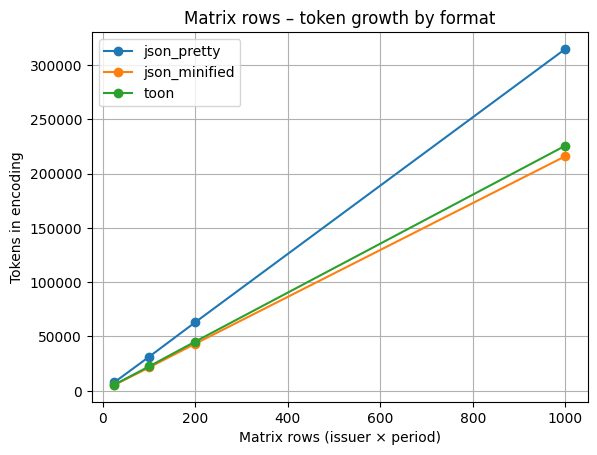


Implied TOON savings on Matrix rows vs pretty JSON ≈ 28.3%


In [ ]:
fit_results = {}

for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_matrix[df_matrix["Format"] == mode].sort_values("Rows")
    x = sub["Rows"].values.astype(float)
    y = sub["Tokens"].values.astype(float)
    # Linear fit: y ≈ a + b * x
    b, a = np.polyfit(x, y, 1)
    fit_results[mode] = {"intercept": a, "slope": b}

print("Approximate token cost per additional Matrix row:")
for mode, params in fit_results.items():
    print(
        f"  {mode:>12} → {params['slope']:.2f} tokens/row   "
        f"(intercept ≈ {params['intercept']:.0f} tokens)"
    )

per_row_savings_vs_pretty = (
    fit_results["json_pretty"]["slope"] - fit_results["toon"]["slope"]
)
per_row_savings_vs_min = (
    fit_results["json_minified"]["slope"] - fit_results["toon"]["slope"]
)

print("\nMarginal savings vs TOON:")
print(f"  vs pretty JSON   : {per_row_savings_vs_pretty:.2f} tokens/row")
print(f"  vs minified JSON : {per_row_savings_vs_min:.2f} tokens/row")

# Optional but nice: visual sanity check
plt.figure()
for mode in ["json_pretty", "json_minified", "toon"]:
    sub = df_matrix[df_matrix["Format"] == mode].sort_values("Rows")
    plt.plot(sub["Rows"], sub["Tokens"], marker="o", label=mode)

plt.xlabel("Matrix rows (issuer × period)")
plt.ylabel("Tokens in encoding")
plt.title("Matrix rows – token growth by format")
plt.legend()
plt.grid(True)
plt.show()

# Save a number we’ll use later in the Hebbia-scale cost analysis
OBSERVED_SAVINGS_MATRIX_PERCENT = (
    100
    * (fit_results["json_pretty"]["slope"] - fit_results["toon"]["slope"])
    / fit_results["json_pretty"]["slope"]
)
print(f"\nImplied TOON savings on Matrix rows vs pretty JSON ≈ {OBSERVED_SAVINGS_MATRIX_PERCENT:.1f}%")
